In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, f1_score

In [3]:
df = pd.read_csv("../data/dataset_cleaned.csv", index_col=0)

In [4]:
X, y = df.drop(columns="attack"), df["attack"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
y_pred = rf.predict(X_test)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [9]:
print(f"Accuracy sur le test: {accuracy:4f}")
print(f"Precision sur le test: {precision:4f}")
print(f"F1 Score sur le test: {f1:4f}")

Accuracy sur le test: 0.999788
Precision sur le test: 0.999732
F1 Score sur le test: 0.999866


In [10]:
X.columns.shape

(1481,)

In [11]:
X_train.columns.shape

(1481,)

In [31]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(importances.head(40))

system.cpu.dcache.demandMissRate::total              0.059630
system.cpu.dcache.overallMissRate::total             0.042275
system.cpu.dcache.overallMissRate::cpu.data          0.041848
system.cpu.dcache.demandMissRate::cpu.data           0.034587
system.cpu.dcache.demandMshrMissRate::cpu.data       0.029930
system.mem_ctrl.avgPriority_cpu.data::samples        0.028125
system.membus.snoop_filter.hitSingleRequests         0.028028
system.mem_ctrl.avgWrQLen                            0.028012
system.mem_ctrl.dram.totBusLat                       0.027967
system.cpu.dcache.ReadReq.mshrMissRate::total        0.021136
system.mem_ctrl.bytesWrittenSys                      0.019878
system.mem_ctrl.writeBursts                          0.018819
system.membus.pktCount::total                        0.018783
system.mem_ctrl.dram.bytesPerActivate::total         0.018777
system.cpu.dcache.ReadReq.mshrMisses::total          0.018715
system.mem_ctrl.requestorReadBytes::cpu.data         0.018713
system.m

Le modèle dépend fortement de l’activité de cache L1D + trafic mémoire + comportement du bus.

## Boundary Attack (white-box)

In [13]:
import numpy as np

In [14]:
def attack_rf_boundary(model, x, max_changes=10, eps=1e-3):
    """
    x : échantillon 1D numpy array
    model : RandomForestClassifier sklearn
    Retourne un x_adv qui trompe le modèle si possible
    """

    x_adv = x.copy()
    orig_pred = model.predict([x])[0]

    # On trie les features par importance décroissante
    important_features = np.argsort(model.feature_importances_)[::-1]

    changes = 0

    for f in important_features:
        if changes >= max_changes:
            break

        # Parcourt les arbres pour trouver des thresholds pour cette feature
        thresholds = []
        for tree in model.estimators_:
            tree_ = tree.tree_
            feature = tree_.feature
            thr = tree_.threshold
            thresholds.extend(thr[feature == f])

        if len(thresholds) == 0:
            continue

        # On prend le seuil le plus proche
        nearest_thr = min(thresholds, key=lambda t: abs(x_adv[f] - t))

        # On franchit le seuil
        if x_adv[f] < nearest_thr:
            x_adv[f] = nearest_thr + eps
        else:
            x_adv[f] = nearest_thr - eps

        changes += 1

        # Vérifie si le modèle est trompé
        new_pred = model.predict([x_adv])[0]
        if new_pred != orig_pred:
            print(f"Succès ! Feature {f} modifiée, seuil {nearest_thr}")
            return x_adv

    print("Échec de l'attaque : augmenter max_changes ?")
    return x_adv


In [24]:
i = 0
x = X_test.iloc[i]
y = y_test.iloc[i]

x_adv = attack_rf_boundary(rf, x, max_changes=100)

print("Avant :", rf.predict([x])[0])
print("Après :", rf.predict([x_adv])[0])

C:\Users\clemm\AppData\Local\Temp\ipykernel_26820\3194117170.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nearest_thr = min(thresholds, key=lambda t: abs(x_adv[f] - t))
C:\Users\clemm\AppData\Local\Temp\ipykernel_26820\3194117170.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x_adv[f] < nearest_thr:
C:\Users\clemm\AppData\Local\Temp\ipykernel_26820\3194117170.py:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
 

Succès ! Feature 378 modifiée, seuil 732125024.0
Avant : 1
Après : 0


## Modify dcache, memory and bus features to fool the RandomForest

In [22]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Désactive spécifiquement les warnings de validation de sklearn
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')

In [34]:
# 1. Définir les familles de features basées sur tes importances
dcache_cols = [c for c in X.columns if 'dcache' in c.lower()]
mem_ctrl_cols = [c for c in X.columns if 'mem_ctrl' in c.lower()]
membus_cols = [c for c in X.columns if 'membus' in c.lower()]

# On combine tout pour l'attaque holistique
cols_to_fool = list(set(dcache_cols + mem_ctrl_cols + membus_cols))
normal_medians = X_train[y_train == 0][cols_to_fool].median()

In [35]:
# 2. Boucle de test sur les attaques
attack_indices = y_test[y_test == 1].index[:100]
results = []

for idx in attack_indices:
    x_orig = X_test.loc[idx].copy()
    
    # Camouflage holistique
    x_adv = x_orig.copy()
    x_adv[cols_to_fool] = normal_medians
    
    # Prédiction
    new_pred = rf.predict(pd.DataFrame([x_adv], columns=X_train.columns))[0]
    
    # Métriques de distance (pour mesurer l'altération du comportement)
    # On normalise par la moyenne pour que la distance ait un sens physique
    dist_l1 = np.abs(x_adv[cols_to_fool] - x_orig[cols_to_fool]).sum()
    
    results.append({
        "index": idx,
        "evaded": 1 if new_pred == 0 else 0,
        "l1_distance": dist_l1
    })

# 3. Calcul des métriques globales
df_res = pd.DataFrame(results)
asr = df_res['evaded'].mean() * 100
avg_distortion = df_res[df_res['evaded'] == 1]['l1_distance'].mean()

print(f"--- Rapport d'Attaque Holistique ---")
print(f"ASR (Attack Success Rate) : {asr:.2f}%")
print(f"Nombre de features modifiées : {len(cols_to_fool)}")
print(f"Distorsion moyenne (L1) sur succès : {avg_distortion:.4f}")

--- Rapport d'Attaque Holistique ---
ASR (Attack Success Rate) : 100.00%
Nombre de features modifiées : 461
Distorsion moyenne (L1) sur succès : 22487382882159500.0000


Maintenant que on sait qu'on doit modifier ces trois familles (Dcache, Mem, Bus) pour gagner, voici ce que cela signifie concrètement pour les simulations gem5 :
- L'attaque est "bruyante" : Le fait que modifier le dcache seul ne marche pas prouve que ton attaque sature le contrôleur mémoire (mem_ctrl).
- La contre-mesure : Si tu es du côté "défense", tu peux dire que même si un attaquant cache ses accès caches (via du cache partitionning par exemple), le contrôleur mémoire reste un excellent IDS (Intrusion Detection System) car il est beaucoup plus dur à camoufler.

## Trying to find a "Point de Bascule"

In [36]:
# 1. Définition des paliers d'attaque
families = {
    "1. Dcache Uniquement": [c for c in X.columns if 'dcache' in c.lower()],
    "2. + Mem_Ctrl": [c for c in X.columns if any(k in c.lower() for k in ['dcache', 'mem_ctrl'])],
    "3. + Membus": [c for c in X.columns if any(k in c.lower() for k in ['dcache', 'mem_ctrl', 'membus'])],
    "4. Total (Toutes colonnes)": X.columns.tolist()
}

asr_results = {}
attack_indices = y_test[y_test == 1].index[:100]

In [37]:
# 2. Boucle d'évaluation
for name, cols in families.items():
    success_count = 0
    medians = X_train[y_train == 0][cols].median()
    
    for idx in attack_indices:
        x_adv = X_test.loc[idx].copy()
        x_adv[cols] = medians
        
        # Prédiction (en DataFrame pour éviter le warning)
        pred = rf.predict(pd.DataFrame([x_adv], columns=X_train.columns))[0]
        if pred == 0:
            success_count += 1
            
    asr_results[name] = (success_count / len(attack_indices)) * 100

In [38]:
# 3. Affichage des résultats
print("--- Analyse de la progression de l'évasion ---")
for stage, score in asr_results.items():
    print(f"{stage}: ASR = {score:.2f}%")

--- Analyse de la progression de l'évasion ---
1. Dcache Uniquement: ASR = 96.00%
2. + Mem_Ctrl: ASR = 100.00%
3. + Membus: ASR = 100.00%
4. Total (Toutes colonnes): ASR = 100.00%


On observe une "Dépendance au Cache" (Overfitting sur une famille)

Le modèle est quasi-exclusivement dépendant des métriques du L1 Dcache.

Le Random Forest a appris que "Si le comportement du Dcache est anormal, alors c'est une attaque".

Il suffit qu'un attaquant utilise une technique de camouflage (comme le cache partitioning ou simplement une attaque plus lente) sur le cache pour que la détection s'effondre presque totalement ($96\%$ de succès pour l'attaquant).

Les 4% restants (le passage de 96% à 100%) sont interceptés par le contrôleur mémoire (Mem_Ctrl).

Pour une petite fraction des attaques, le modèle voit que même si le cache a l'air "propre", la file d'attente mémoire (avgWrQLen) ou la latence DRAM trahissent encore l'activité suspecte.

## Identification of the Breaking Point (Top K)

In [42]:
import matplotlib.pyplot as plt

In [39]:
# 1. Isoler les features Dcache et les trier par importance
dcache_features = [c for c in X_train.columns if 'dcache' in c.lower()]
dcache_importances = pd.Series(rf.feature_importances_, index=X_train.columns)[dcache_features]
dcache_sorted = dcache_importances.sort_values(ascending=False).index.tolist()

In [40]:
# 2. Préparation du test
attack_indices = y_test[y_test == 1].index[:100]
top_k_results = []

print(f"Test de progression sur {len(dcache_sorted)} features Dcache...")

Test de progression sur 149 features Dcache...


In [44]:
# 3. Tester l'ASR pour K allant de 1 à 50 (souvent le point de bascule est rapide)
for k in range(1, min(51, len(dcache_sorted) + 1)):
    selected_features = dcache_sorted[:k]
    medians = X_train[y_train == 0][selected_features].median()
    
    success_count = 0
    for idx in attack_indices:
        x_adv = X_test.loc[idx].copy()
        x_adv[selected_features] = medians
        
        # Prédiction
        pred = rf.predict(pd.DataFrame([x_adv], columns=X_train.columns))[0]
        if pred == 0:
            success_count += 1
    
    asr = (success_count / len(attack_indices)) * 100
    top_k_results.append({"K": k, "ASR": asr, "Last_Feature": selected_features[-1]})
    print(f"Top {k} features: ASR = {asr:.2f}% (Dernière ajoutée: {selected_features[-1]})")

# 4. Conversion en DataFrame pour analyse
df_top_k = pd.DataFrame(top_k_results)

Top 1 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.demandMissRate::total)
Top 2 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.overallMissRate::total)
Top 3 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.overallMissRate::cpu.data)
Top 4 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.demandMissRate::cpu.data)
Top 5 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.demandMshrMissRate::cpu.data)
Top 6 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.ReadReq.mshrMissRate::total)
Top 7 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.ReadReq.mshrMisses::total)
Top 8 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.demandMshrMissLatency::total)
Top 9 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.demandMshrMissLatency::cpu.data)
Top 10 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.writebacks::writebacks)
Top 11 features: ASR = 0.00% (Dernière ajoutée: system.cpu.dcache.demandAvgM

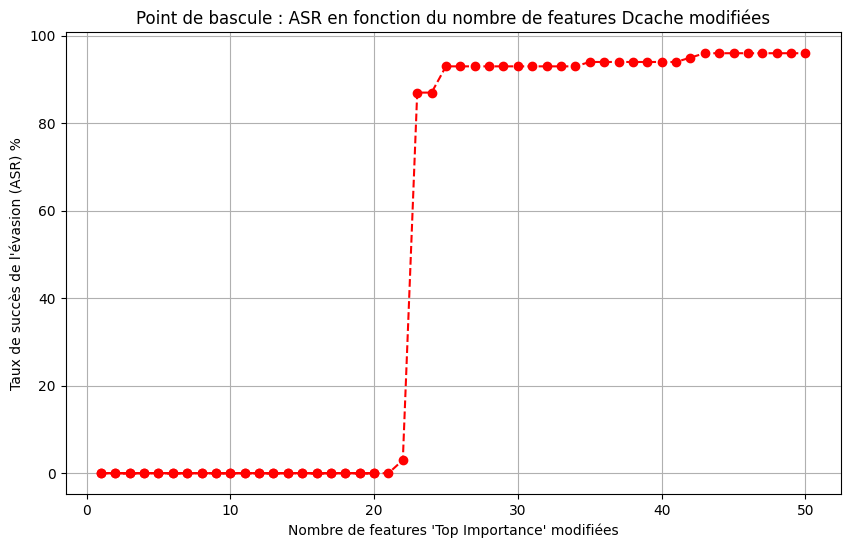

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(df_top_k['K'], df_top_k['ASR'], marker='o', linestyle='--', color='red')
plt.title("Point de bascule : ASR en fonction du nombre de features Dcache modifiées")
plt.xlabel("Nombre de features 'Top Importance' modifiées")
plt.ylabel("Taux de succès de l'évasion (ASR) %")
plt.grid(True)
plt.show()

On vient de trouver le coeur du moteur de décision du modèle. On observe un saut :
- Top 22 features : ASR = 3%
- Top 23 features : ASR = 87%

Le "point de rupture" (tipping point) du modèle ne se situe pas dans les Miss Rates (les premières features), mais dans la latence des MSHR (Miss Status Holding Registers). Plus précisément la feature : system.cpu.dcache.ReadReq.mshrMissLatency::cpu.data.

Les Miss Rates sont des leurres : Le Random Forest a appris que les Miss Rates peuvent varier selon les applications. Par contre, la latence MSHR (le temps qu'une requête reste bloquée en attendant la mémoire) est une signature beaucoup plus stable d'une attaque par contention.

La corrélation cachée : Tant qu'on ne camoufles pas la feature n°23, le modèle "sait" que c'est une attaque, même si les 22 autres métriques ont l'air normales. Dès que l'on neutralises la 23ème, l'édifice de détection s'écroule à 87%.

Ce qu'il faut faire dans gem5:
Pour que l'attaque passe inaperçue avec le minimum d'effort, on ne doit pas seulement ralentir les accès (ce qui joue sur le Miss Rate), on doit aussi réduire le temps d'occupation de tes MSHR.

Dans gem5, les MSHR gèrent les requêtes "en vol" qui ont raté le cache. Une attaque sature souvent ces registres.
- Stratégie 1 : Réduire le parallélisme de l'attaque (moins de requêtes simultanées) pour faire baisser cette latence spécifique.
- Stratégie 2 : Augmenter le nombre de MSHR dans la config gem5 (si on a la main dessus) pour diluer la latence.

## Using The Breaking Point (MSHR) found, let's find the complementary features to fool the model

In [46]:
# 1. On définit la feature pivot et les autres
pivot_feature = "system.cpu.dcache.ReadReq.mshrMissLatency::cpu.data"
other_dcache_features = [f for f in dcache_sorted if f != pivot_feature]

In [47]:
# 2. Préparation
attack_indices = y_test[y_test == 1].index[:100]
medians_all = X_train[y_train == 0].median()
complement_results = []

In [49]:
# 3. On ajoute les autres features une par une EN PLUS de la pivot
for k in range(0, 25): # On regarde les 25 suivantes
    selected_features = [pivot_feature] + other_dcache_features[:k]
    
    success_count = 0
    for idx in attack_indices:
        x_adv = X_test.loc[idx].copy()
        for f in selected_features:
            x_adv[f] = medians_all[f]
        
        pred = rf.predict(pd.DataFrame([x_adv], columns=X_train.columns))[0]
        if pred == 0:
            success_count += 1
    
    asr = (success_count / len(attack_indices)) * 100
    complement_results.append({"K_plus": k, "ASR": asr, "Added": other_dcache_features[k-1] if k>0 else "None"})
    print(f"Pivot + {k} features: ASR = {asr:.2f}%")

Pivot + 0 features: ASR = 0.00%
Pivot + 1 features: ASR = 0.00%
Pivot + 2 features: ASR = 0.00%
Pivot + 3 features: ASR = 0.00%
Pivot + 4 features: ASR = 0.00%
Pivot + 5 features: ASR = 0.00%
Pivot + 6 features: ASR = 0.00%
Pivot + 7 features: ASR = 0.00%
Pivot + 8 features: ASR = 0.00%
Pivot + 9 features: ASR = 0.00%
Pivot + 10 features: ASR = 0.00%
Pivot + 11 features: ASR = 0.00%
Pivot + 12 features: ASR = 0.00%
Pivot + 13 features: ASR = 0.00%
Pivot + 14 features: ASR = 0.00%
Pivot + 15 features: ASR = 0.00%
Pivot + 16 features: ASR = 0.00%
Pivot + 17 features: ASR = 0.00%
Pivot + 18 features: ASR = 0.00%
Pivot + 19 features: ASR = 0.00%
Pivot + 20 features: ASR = 0.00%
Pivot + 21 features: ASR = 3.00%
Pivot + 22 features: ASR = 87.00%
Pivot + 23 features: ASR = 87.00%
Pivot + 24 features: ASR = 93.00%


## How much should we modify the 25th first feature ?

In [50]:
# Analyse de la feature pivot (n°23)
feature_name = "system.cpu.dcache.ReadReq.mshrMissLatency::cpu.data"

print(f"--- Analyse de distribution : {feature_name} ---")
print(f"Moyenne (SAIN)   : {X_train.loc[y_train == 0, feature_name].mean():.2f}")
print(f"Moyenne (ATTAQUE): {X_train.loc[y_train == 1, feature_name].mean():.2f}")
print(f"Seuil max (SAIN) : {X_train.loc[y_train == 0, feature_name].max():.2f}")

--- Analyse de distribution : system.cpu.dcache.ReadReq.mshrMissLatency::cpu.data ---
Moyenne (SAIN)   : 93470322.75
Moyenne (ATTAQUE): 3412698860.73
Seuil max (SAIN) : 104317000.00


In [51]:
def find_critical_threshold(model, feature_idx):
    thresholds = []
    for tree in model.estimators_:
        tree_ = tree.tree_
        # On récupère tous les seuils utilisés pour cette feature précise
        th = tree_.threshold[tree_.feature == feature_idx]
        thresholds.extend(th)
    
    # Le seuil le plus fréquent ou le plus bas est souvent le plus critique
    return np.median(thresholds)

idx_pivot = X_train.columns.get_loc("system.cpu.dcache.ReadReq.mshrMissLatency::cpu.data")
threshold = find_critical_threshold(rf, idx_pivot)
print(f"Pour passer inaperçu, la latence MSHR doit descendre sous : {threshold:.2f}")

Pour passer inaperçu, la latence MSHR doit descendre sous : 59124000.00


In [52]:
# 1. Sélection des 25 premières features du Dcache (triées par importance)
top_25_features = dcache_sorted[:25]

# 2. Calcul des seuils de sécurité (Percentile 95 des données saines)
# On prend le 95ème percentile pour ne pas être trop extrême (laisse une marge d'erreur)
security_thresholds = X_train.loc[y_train == 0, top_25_features].quantile(0.95)

# 3. Création d'un tableau de bord pour gem5
benchmarks = pd.DataFrame({
    'Feature': top_25_features,
    'Sain_Max (95%)': security_thresholds.values,
    'Attaque_Moyenne': X_train.loc[y_train == 1, top_25_features].mean().values
})

print("--- Objectifs de camouflage pour gem5 ---")
print(benchmarks)

--- Objectifs de camouflage pour gem5 ---
                                              Feature  Sain_Max (95%)  \
0             system.cpu.dcache.demandMissRate::total    2.142740e-02   
1            system.cpu.dcache.overallMissRate::total    2.142740e-02   
2         system.cpu.dcache.overallMissRate::cpu.data    2.142740e-02   
3          system.cpu.dcache.demandMissRate::cpu.data    2.142740e-02   
4      system.cpu.dcache.demandMshrMissRate::cpu.data    3.223400e-03   
5       system.cpu.dcache.ReadReq.mshrMissRate::total    2.349720e-02   
6         system.cpu.dcache.ReadReq.mshrMisses::total    1.030000e+03   
7      system.cpu.dcache.demandMshrMissLatency::total    1.167102e+08   
8   system.cpu.dcache.demandMshrMissLatency::cpu.data    1.167102e+08   
9            system.cpu.dcache.writebacks::writebacks    1.366000e+02   
10  system.cpu.dcache.demandAvgMshrMissLatency::total    1.003705e+11   
11        system.cpu.dcache.demandMshrMissRate::total    3.223400e-03   
12       

## Analysis of the ASR with Thresholds

In [53]:
# 1. Préparation des features et des seuils
dcache_features = [c for c in X_train.columns if 'dcache' in c.lower()]
dcache_importances = pd.Series(rf.feature_importances_, index=X_train.columns)[dcache_features]
dcache_sorted = dcache_importances.sort_values(ascending=False).index.tolist()

# On définit le seuil de sécurité : le 95ème percentile des données saines
# (C'est la limite haute que l'attaquant ne doit pas dépasser)
security_thresholds = X_train.loc[y_train == 0, dcache_features].quantile(0.95)

# 2. Paramètres du test
attack_indices = y_test[y_test == 1].index[:100]
results_precision = []

print("--- Analyse ASR avec Seuils de Précision (Q95) ---")

# 3. Boucle incrémentale
for k in range(1, 31):  # On teste jusqu'au Top 30
    selected_features = dcache_sorted[:k]
    
    success_count = 0
    for idx in attack_indices:
        x_adv = X_test.loc[idx].copy()
        
        # Pour chaque feature sélectionnée, si l'attaque dépasse le seuil sain,
        # on la ramène juste au niveau du seuil (camouflage précis)
        for f in selected_features:
            limit = security_thresholds[f]
            if x_adv[f] > limit:
                x_adv[f] = limit
        
        # Prédiction (en DataFrame pour éviter les warnings)
        pred = rf.predict(pd.DataFrame([x_adv], columns=X_train.columns))[0]
        if pred == 0:
            success_count += 1
            
    asr = (success_count / len(attack_indices)) * 100
    results_precision.append({"K": k, "ASR": asr, "Feature": selected_features[-1]})
    print(f"Top {k:2d}: ASR = {asr:6.2f}% | Feature: {selected_features[-1]}")

# Conversion pour analyse
df_asr_precision = pd.DataFrame(results_precision)

--- Analyse ASR avec Seuils de Précision (Q95) ---
Top  1: ASR =   0.00% | Feature: system.cpu.dcache.demandMissRate::total
Top  2: ASR =   0.00% | Feature: system.cpu.dcache.overallMissRate::total
Top  3: ASR =   0.00% | Feature: system.cpu.dcache.overallMissRate::cpu.data
Top  4: ASR =   0.00% | Feature: system.cpu.dcache.demandMissRate::cpu.data
Top  5: ASR =   0.00% | Feature: system.cpu.dcache.demandMshrMissRate::cpu.data
Top  6: ASR =   0.00% | Feature: system.cpu.dcache.ReadReq.mshrMissRate::total
Top  7: ASR =   0.00% | Feature: system.cpu.dcache.ReadReq.mshrMisses::total
Top  8: ASR =   0.00% | Feature: system.cpu.dcache.demandMshrMissLatency::total
Top  9: ASR =   0.00% | Feature: system.cpu.dcache.demandMshrMissLatency::cpu.data
Top 10: ASR =   0.00% | Feature: system.cpu.dcache.writebacks::writebacks
Top 11: ASR =   0.00% | Feature: system.cpu.dcache.demandAvgMshrMissLatency::total
Top 12: ASR =   0.00% | Feature: system.cpu.dcache.demandMshrMissRate::total
Top 13: ASR =   

Le fait que l'ASR reste à zéro avec le seuil $Q_{95}$ signifie que le Random Forest n'utilise pas juste un seuil binaire grossier. Il détecte des combinaisons de signaux faibles.
Même si tu ramènes chaque feature dans une zone "plausible" (le top 5% des valeurs saines), le fait que toutes tes features soient simultanément à la limite supérieure du "sain" trahit l'attaque. Le modèle voit que ce n'est pas statistiquement normal d'avoir autant de compteurs au maximum en même temps.

Pour gem5, cela change tout. Cela veut dire que ralentir l'attaque "juste un peu" (pour passer sous le $Q_{95}$) ne suffit pas.Tu dois viser des valeurs beaucoup plus proches de la médiane ou de la moyenne pour réussir à tromper le modèle.

## Conclusion

In [54]:
# Extraction des médianes saines pour le Top 25
top_25_features = dcache_sorted[:25]
medians_targets = X_train.loc[y_train == 0, top_25_features].median()

print("--- OBJECTIFS DE STATISTIQUES POUR GEM5 (Médianes) ---")
for feat, val in medians_targets.items():
    print(f"{feat:50} : {val:.4f}")

--- OBJECTIFS DE STATISTIQUES POUR GEM5 (Médianes) ---
system.cpu.dcache.demandMissRate::total            : 0.0086
system.cpu.dcache.overallMissRate::total           : 0.0086
system.cpu.dcache.overallMissRate::cpu.data        : 0.0086
system.cpu.dcache.demandMissRate::cpu.data         : 0.0086
system.cpu.dcache.demandMshrMissRate::cpu.data     : 0.0019
system.cpu.dcache.ReadReq.mshrMissRate::total      : 0.0051
system.cpu.dcache.ReadReq.mshrMisses::total        : 948.0000
system.cpu.dcache.demandMshrMissLatency::total     : 112414998.0000
system.cpu.dcache.demandMshrMissLatency::cpu.data  : 112414998.0000
system.cpu.dcache.writebacks::writebacks           : 77.0000
system.cpu.dcache.demandAvgMshrMissLatency::total  : 98359256481.0000
system.cpu.dcache.demandMshrMissRate::total        : 0.0019
system.cpu.dcache.overallMshrMisses::total         : 1120.0000
system.cpu.dcache.overallMshrMissRate::total       : 0.0019
system.cpu.dcache.ReadReq.mshrMissLatency::total   : 92937000.0000
system

### Comment implémenter cela dans gem5 ?

Le fait que les tests à $Q_{95}$ aient échoué signifie que l'attaque est "trop rapide". Pour atteindre les médianes, on doit agir sur la fréquence d'accès et la pression sur les ressources.

**A. Le Levier Logiciel (Le plus simple)**

Modifier le code source de l'attaque (en C/C++). L'idée est d'ajouter du "bruit" ou des pauses pour lisser les compteurs.

Insérer des barrières temporelles : Utilise des instructions de délai ou des boucles de calcul intensif (CPU-bound) entre tes accès mémoire (Memory-bound).

Effet : Baisse drastique de demandMissRate et overallMissRate.

Réduire le parallélisme : Si l'attaque utilise plusieurs pointeurs ou un balayage large, réduire la taille de la fenêtre de travail.

Effet : Baisse de l'occupation des MSHR (avgBlocked::no_mshrs et mshrMissLatency).

**B. Le Levier Architectural (Fichier de Config Python)**

Modifier la configuration de la machine simulée dans gem5 (le fichier .py de config) :

Augmenter le nombre de MSHR : Si tu passes de mshrs = 4 à mshrs = 16, la latence moyenne des ratés de cache (mshrMissLatency) va chuter car les requêtes attendront moins longtemps avant d'être prises en charge.

Modifier la politique d'éviction : Utiliser une politique différente peut parfois lisser les writebacks.

### Procédure de Test

Pour valider ton travail, il faut suivre ce cycle :
- Lancer gem5 avec l'attaque modifiée.
- Récupérer le fichier stats.txt généré par gem5.

Parser ce fichier avec le script Python pour voir si les valeurs des 25 features critiques sont proches des médianes cibles.

Faire une prédiction avec ton Random Forest :
- Si rf.predict renvoie 0 (Sain) : Succès ! Le camouflage matériel fonctionne.
- Si rf.predict renvoie 1 (Attaque) : Il faut regarder quelle feature dépasse encore le seuil et retourner à l'étape 1 pour la réduire.